In [1]:
import pandas as pd
import s3fs
import io
# PV data link https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=pvdaq%2Fcsv%2Fpvdata%2Fsystem_id%3D11487%2F
# The base S3 URI for the system
s3_base_uri = 's3://oedi-data-lake/pvdaq/csv/pvdata/system_id=11487/'
s3_wildcard_path = s3_base_uri + '**/*.csv'

fs = s3fs.S3FileSystem(anon=True)

try:
    csv_paths = fs.glob(s3_wildcard_path)
    csv_files = [f's3://{path}' for path in csv_paths]

    if not csv_files:
        print("Error: No CSV files found using the wildcard path.")
    else:
        print(f"Found {len(csv_files)} files. Inspecting first file...")

        # Find the Correct Date Column
        with fs.open(csv_files[0], 'rb') as f:
            temp_df = pd.read_csv(io.BytesIO(f.read()), nrows=5)
            all_cols = temp_df.columns.tolist()

        # Identify the most likely timestamp column based on common names
        time_candidates = ['time', 'date', 'datetime', 'dt_utc', 'dt_iso', 'ts']
        date_col = next((col for col in all_cols if col.lower() in time_candidates), None)
        
        # If a common name isn't found, assume the first column is the date
        if not date_col and len(all_cols) > 0:
             date_col = all_cols[0]

        if not date_col:
            raise ValueError("Could not automatically identify a timestamp column.")

        print(f"Identified timestamp column as: '{date_col}'")
        
        # Read and Concatenate All Files 
        print("Reading and concatenating data...")
        df_list = []
        for file in csv_files:
            # Use the identified date column for parsing
            df_list.append(pd.read_csv(file, parse_dates=[date_col]))

        pv_data = pd.concat(df_list, ignore_index=True)
        
        # 3. Display confirmation and clean up the index
        pv_data = pv_data.sort_values(by=date_col).reset_index(drop=True)
        
        print("---")
        print("Data successfully loaded and combined.")
        print(f"Total rows in DataFrame: {len(pv_data)}")
        print(f"Columns: {list(pv_data.columns)}")
        print("\nFirst 5 rows:")
        print(pv_data.head())

except Exception as e:
    print(f"An error occurred during file access: {e}")

Found 10 files. Inspecting first file...
Identified timestamp column as: 'Unnamed: 0'
Reading and concatenating data...
---
Data successfully loaded and combined.
Total rows in DataFrame: 3160
Columns: ['Unnamed: 0', 'ac_power_inv_21445_daily_max', 'ac_power_inv_21445_daily_mean', 'ac_energy_inv_21445_daily_sum']

First 5 rows:
  Unnamed: 0  ac_power_inv_21445_daily_max  ac_power_inv_21445_daily_mean  \
0 2016-04-27                         3.380                       1.536995   
1 2016-04-28                         3.572                       1.563304   
2 2016-04-29                         3.577                       1.517958   
3 2016-04-30                         3.387                       0.901047   
4 2016-05-01                         3.643                       1.184036   

   ac_energy_inv_21445_daily_sum  
0                         24.385  
1                         24.883  
2                         24.287  
3                         14.342  
4                         18.945

In [2]:
pv_data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
pv_data.head()

,Date,ac_power_inv_21445_daily_max,ac_power_inv_21445_daily_mean,ac_energy_inv_21445_daily_sum
0,2016-04-27,3.380,1.536995,24.385
1,2016-04-28,3.572,1.563304,24.883
2,2016-04-29,3.577,1.517958,24.287
3,2016-04-30,3.387,0.901047,14.342
4,2016-05-01,3.643,1.184036,18.945


In [3]:
# 1. Ensure the 'Date' column is in datetime format
pv_data['Date'] = pd.to_datetime(pv_data['Date'])

# 2. Set the 'Date' column as the index and sort
pv_data = pv_data.set_index('Date').sort_index()

# 3. Rename the target column for simplicity
# Your target is the daily energy sum: 'ac_energy_inv_21445_daily_sum'
pv_data.rename(columns={'ac_energy_inv_21445_daily_sum': 'Total_kWh'}, inplace=True) 

pv_data.head()

,ac_power_inv_21445_daily_max,ac_power_inv_21445_daily_mean,Total_kWh
Date,,,
2016-04-27,3.380,1.536995,24.385
2016-04-28,3.572,1.563304,24.883
2016-04-29,3.577,1.517958,24.287
2016-04-30,3.387,0.901047,14.342
2016-05-01,3.643,1.184036,18.945


In [4]:
# Check for NaNs and fill, if necessary. For daily energy, filling with 0 is often simple:
pv_data['Total_kWh'] = pv_data['Total_kWh'].fillna(0)

# Ensure energy is not negative:
pv_data.loc[pv_data['Total_kWh'] < 0, 'Total_kWh'] = 0

In [5]:
pv_data['Day_of_Year'] = pv_data.index.day_of_year
pv_data['Day_of_Week'] = pv_data.index.dayofweek # 0=Monday, 6=Sunday
pv_data['Month'] = pv_data.index.month


In [6]:
# Rename for clarity
pv_data.rename(columns={'ac_power_inv_21445_daily_max': 'Power_Max', 
                        'ac_power_inv_21445_daily_mean': 'Power_Mean'}, inplace=True) 


import requests
import pandas as pd
import urllib.parse
import time
 ## data URL: https://nsrdb.nrel.gov/data-viewer
API_KEY = "kqrttpYYUcxix5pCW7wO5pysSE8wJ0XaYShbxnDf"
EMAIL = "jbahret2@illinois.edu"
BASE_URL = "https://developer.nrel.gov/api/nsrdb/v2/solar/nsrdb-GOES-aggregated-v4-0-0-download.json?"
POINTS = [
'205581'
]

def main():
    input_data = {
        'attributes': 'air_temperature,cloud_type,clearsky_ghi,ghi,ghuv-295-385,wind_speed',
        'interval': '60',
        'include_leap_day': 'true',
        
        'api_key': API_KEY,
        'email': EMAIL,
    }
    for name in ['2016','2017','2018','2019','2020','2021','2022','2023','2024']:
        print(f"Processing name: {name}")
        for id, location_ids in enumerate(POINTS):
            input_data['names'] = [name]
            input_data['location_ids'] = location_ids
            print(f'Making request for point group {id + 1} of {len(POINTS)}...')

            if '.csv' in BASE_URL:
                url = BASE_URL + urllib.parse.urlencode(data, True)
                # Note: CSV format is only supported for single point requests
                # Suggest that you might append to a larger data frame
                data = pd.read_csv(url)
                print(f'Response data (you should replace this print statement with your processing): {data}')
                # You can use the following code to write it to a file
                # data.to_csv('SingleBigDataPoint.csv')
            else:
                headers = {
                  'x-api-key': API_KEY
                }
                data = get_response_json_and_handle_errors(requests.post(BASE_URL, input_data, headers=headers))
                download_url = data['outputs']['downloadUrl']
                # You can do with what you will the download url
                print(data['outputs']['message'])
                print(f"Data can be downloaded from this url when ready: {download_url}")

                # Delay for 1 second to prevent rate limiting
                time.sleep(1)
            print(f'Processed')


def get_response_json_and_handle_errors(response: requests.Response) -> dict:
    """Takes the given response and handles any errors, along with providing
    the resulting json

    Parameters
    ----------
    response : requests.Response
        The response object

    Returns
    -------
    dict
        The resulting json
    """
    if response.status_code != 200:
        print(f"An error has occurred with the server or the request. The request response code/status: {response.status_code} {response.reason}")
        print(f"The response body: {response.text}")
        exit(1)

    try:
        response_json = response.json()
    except:
        print(f"The response couldn't be parsed as JSON, likely an issue with the server, here is the text: {response.text}")
        exit(1)

    if len(response_json['errors']) > 0:
        errors = '\n'.join(response_json['errors'])
        print(f"The request errored out, here are the errors: {errors}")
        exit(1)
    return response_json

if __name__ == "__main__":
    main()

In [7]:
import pandas as pd
import os

# Define the directory where your files are located
directory_path = '/Users/joeybahret/Documents/Grad_School/ATMS_523/Module 8/ATMS-523-M8/nsrdb_data/' 
years = [year for year in range(2016,2025)]

#  Filter the list to include only years 2016 through 2024 
files_to_read = []
for year in years:
    filename = f'205581_34.61_-118.18_{year}.csv'
    files_to_read.append(directory_path+ filename)
    
# Read the filtered files and combine them ---
df_list = []

combined_df = pd.concat((pd.read_csv(f, header =2) for f in files_to_read), ignore_index=True)
combined_df

,Year,Month,Day,Hour,Minute,Temperature,Cloud Type,Clearsky GHI,GHI,Global Horizontal UV Irradiance (295-385nm),Wind Speed
0,2016,1,1,0,30,4.3,0,43,43,0.0000,2.0
1,2016,1,1,1,30,2.5,0,0,0,0.0000,1.9
2,2016,1,1,2,30,1.7,0,0,0,0.0000,2.0
3,2016,1,1,3,30,1.1,1,0,0,0.0000,2.1
4,2016,1,1,4,30,0.6,1,0,0,0.0000,2.2
...,...,...,...,...,...,...,...,...,...,...,...
78907,2024,12,31,19,30,18.8,0,584,577,25.1598,4.2
78908,2024,12,31,20,30,20.0,0,580,580,25.2567,3.7
78909,2024,12,31,21,30,20.2,0,512,484,20.5958,2.9
78910,2024,12,31,22,30,19.4,8,387,327,13.1986,2.2


In [8]:
# Select the date/time columns
date_cols = ['Year', 'Month', 'Day', 'Hour', 'Minute']

# Use pd.to_datetime to combine the columns into a single DatetimeIndex
combined_df['Timestamp'] = pd.to_datetime(combined_df[date_cols])

# Set the new Timestamp column as the index and drop the old component columns
combined_df = combined_df.set_index('Timestamp').drop(columns=date_cols)
combined_df.head()

,Temperature,Cloud Type,Clearsky GHI,GHI,Global Horizontal UV Irradiance (295-385nm),Wind Speed
Timestamp,,,,,,
2016-01-01 00:30:00,4.3,0,43,43,0.0,2.0
2016-01-01 01:30:00,2.5,0,0,0,0.0,1.9
2016-01-01 02:30:00,1.7,0,0,0,0.0,2.0
2016-01-01 03:30:00,1.1,1,0,0,0.0,2.1
2016-01-01 04:30:00,0.6,1,0,0,0.0,2.2


In [9]:
daily_avg_df = combined_df.resample('D').mean()

daily_avg_df.index.rename('Date', inplace=True)
print("Hourly data successfully aggregated to daily means and index is renamed.")

daily_avg_df.head()

Hourly data successfully aggregated to daily means and index is renamed.


,Temperature,Cloud Type,Clearsky GHI,GHI,Global Horizontal UV Irradiance (295-385nm),Wind Speed
Date,,,,,,
2016-01-01,3.541667,1.166667,148.250000,146.958333,6.002779,3.133333
2016-01-02,6.162500,6.083333,146.250000,125.333333,5.152304,2.433333
2016-01-03,7.725000,7.708333,140.708333,112.333333,4.622333,2.241667
2016-01-04,9.050000,5.625000,140.333333,123.208333,5.114033,1.591667
2016-01-05,9.020833,5.000000,141.041667,42.083333,1.674642,2.650000


In [10]:
units = pd.read_csv(directory_path+filename, nrows= 1) #units are agnostic of file name
units = units[units.columns[10:]]
units

,Clearsky DHI Units,Clearsky DNI Units,Clearsky GHI Units,Dew Point Units,DHI Units,DNI Units,GHI Units,Solar Zenith Angle Units,Temperature Units,Pressure Units,...,Cloud Type 11,Cloud Type 12,Fill Flag 0,Fill Flag 1,Fill Flag 2,Fill Flag 3,Fill Flag 4,Fill Flag 5,Surface Albedo Units,Version
0,w/m2,w/m2,w/m2,c,w/m2,w/m2,w/m2,Degree,c,mbar,...,Dust,Smoke,NaN,Missing Image,Low Irradiance,Exceeds Clearsky,Missing CLoud Properties,Rayleigh Violation,NaN,4.1.2.dev4+g3b38bc8.d20250228


In [11]:
import numpy as np
final_daily_df = pv_data.join(
    daily_avg_df, 
    how='inner', 
)
final_daily_df
final_daily_df['sin_day'] = np.sin(2 * np.pi * final_daily_df.index.dayofyear / 365.25)
final_daily_df['cos_day'] = np.cos(2 * np.pi * final_daily_df.index.dayofyear / 365.25)
final_daily_df.head()

,Power_Max,Power_Mean,Total_kWh,Day_of_Year,Day_of_Week,Month,Temperature,Cloud Type,Clearsky GHI,GHI,Global Horizontal UV Irradiance (295-385nm),Wind Speed,sin_day,cos_day
Date,,,,,,,,,,,,,,
2016-04-27,3.380,1.536995,24.385,118,2,4,14.633333,2.041667,335.958333,332.500000,15.327158,2.854167,0.896456,-0.443132
2016-04-28,3.572,1.563304,24.883,119,3,4,12.741667,2.333333,335.791667,326.291667,15.057367,3.320833,0.888701,-0.458487
2016-04-29,3.577,1.517958,24.287,120,4,4,14.287500,0.166667,335.625000,335.625000,15.419550,2.029167,0.880683,-0.473706
2016-04-30,3.387,0.901047,14.342,121,5,4,14.225000,1.166667,336.166667,223.250000,10.184821,2.679167,0.872404,-0.488785
2016-05-01,3.643,1.184036,18.945,122,6,5,16.354167,1.291667,336.958333,262.000000,12.118833,1.358333,0.863867,-0.503720


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define Target and Create Lagged Feature 

# Define the target column
TARGET_COLUMN = 'Power_Mean'

# Create the lagged target feature (predict today's power using yesterday's power)
final_daily_df['Power_lag_1D'] = final_daily_df[TARGET_COLUMN].shift(1)

# Drop the first row which now has NaN for the lagged feature
final_daily_df.dropna(inplace=True)

print("Lagged power feature created and NaN rows removed.")

# Define X (Features) and Y (Target)

# Y is the current day's mean power you are trying to predict
Y = final_daily_df[TARGET_COLUMN]

# X includes the lagged feature and the contemporaneous (same-day) meteorological/seasonal features.
X = final_daily_df[[
    # LAG FEATURE (Most critical for time-series)
    'Power_lag_1D',
    
    # METEOROLOGICAL FEATURES (Already averaged)
    'Clearsky GHI',          # Theoretical max sunlight
    'GHI',                   # Actual observed sunlight
    'Temperature',
    'Wind Speed',
    'Cloud Type',
    
    # SEASONAL FEATURES (Created from the index)
    'sin_day',
    'cos_day'
]]

# Ensure X and Y are perfectly aligned after the final dropna
Y = Y.loc[X.index] 

print("X and Y defined. Ready for splitting.")

Lagged power feature created and NaN rows removed.
X and Y defined. Ready for splitting.


In [13]:
# Use the first 80% of data for training and the last 20% for testing.
split_point = int(len(X) * 0.8)

# Train on the PAST data
X_train, Y_train = X[:split_point], Y[:split_point]

# Test on the FUTURE data
X_test, Y_test = X[split_point:], Y[split_point:]

print(f"Total observations: {len(X)}")
print(f"Training set: {len(X_train)} rows.")
print(f"Testing set: {len(X_test)} rows.")

Total observations: 3133
Training set: 2506 rows.
Testing set: 627 rows.


In [14]:
#  Training 
rf_model = RandomForestRegressor(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1 # Use all cores for speed
)

print("\nStarting Model Training...")
rf_model.fit(X_train, Y_train)
print("Model training complete.")

# Prediction and Evaluation
Y_pred = rf_model.predict(X_test)

# Calculate metrics
rmse_rf = np.sqrt(mean_squared_error(Y_test, Y_pred))
r2_rf = r2_score(Y_test, Y_pred)
corr_rf = np.corrcoef(Y_test, Y_pred)[0, 1]

print("\n--- Model Performance on Test Data ---")
print(f"RMSE (Root Mean Squared Error): {rmse_rf:.4f}")
print(f"R-squared (Coefficient of Determination): {r2_rf:.4f}")
print(f"Correlation (Actual vs. Predicted): {corr_rf:.4f}")


Starting Model Training...
Model training complete.

--- Model Performance on Test Data ---
RMSE (Root Mean Squared Error): 0.0908
R-squared (Coefficient of Determination): 0.9312
Correlation (Actual vs. Predicted): 0.9658


In [15]:
# Assuming your trained model is named 'rf_model' and your features are in 'X_train'

# Extract feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easy viewing and sorting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Top 10 Feature Importances ---")
print(feature_importance_df.head(10))


--- Top 10 Feature Importances ---
        Feature  Importance
2           GHI    0.912744
0  Power_lag_1D    0.025790
3   Temperature    0.013569
6       sin_day    0.011794
4    Wind Speed    0.011086
1  Clearsky GHI    0.010115
5    Cloud Type    0.007767
7       cos_day    0.007135


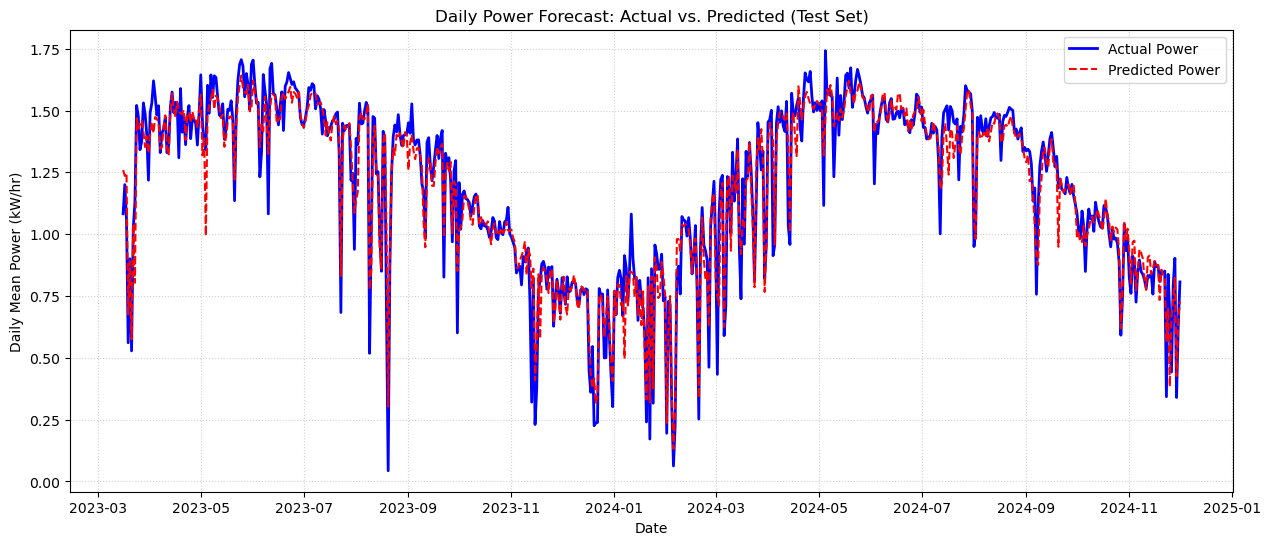

In [16]:
import matplotlib.pyplot as plt

# Combine Actual and Predicted values for plotting
plot_df = pd.DataFrame({
    'Actual_Power': Y_test,
    'Predicted_Power': Y_pred
})

plt.figure(figsize=(15, 6))
plt.plot(plot_df.index, plot_df['Actual_Power'], label='Actual Power', color='blue', linewidth=2)
plt.plot(plot_df.index, plot_df['Predicted_Power'], label='Predicted Power', color='red', linestyle='--', linewidth=1.5)
plt.title('Daily Power Forecast: Actual vs. Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('Daily Mean Power (kW/hr)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

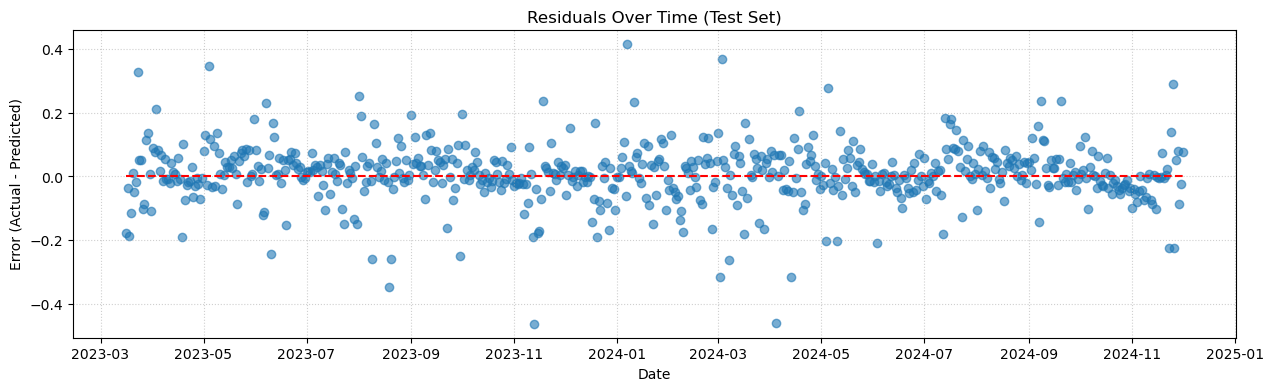

In [17]:
# Calculate residuals
residuals = Y_test - Y_pred

plt.figure(figsize=(15, 4))
plt.scatter(Y_test.index, residuals, alpha=0.6)
plt.hlines(0, Y_test.index[0], Y_test.index[-1], color='red', linestyle='--')
plt.title('Residuals Over Time (Test Set)')
plt.xlabel('Date')
plt.ylabel('Error (Actual - Predicted)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [18]:
TARGET_COLUMN = 'Power_Mean'



# Update your X_forecast to include these

# Create Lagged Meteorological Features
final_daily_df['GHI_lag_1D'] = final_daily_df['GHI'].shift(1)
final_daily_df['Temp_lag_1D'] = final_daily_df['Temperature'].shift(1)
final_daily_df['Wind_Speed_lag_1D'] = final_daily_df['Wind Speed'].shift(1)
final_daily_df['Power_lag_2D'] = final_daily_df['Power_Mean'].shift(2)
final_daily_df['Power_lag_3D'] = final_daily_df['Power_Mean'].shift(3)
final_daily_df['GHI_rolling_7d'] = final_daily_df['GHI'].rolling(7).mean()

# Drop any rows that now have NaN (the first row after the shift)
final_daily_df.dropna(inplace=True)

# Define X (Forecast Features) and Y (Target) 

Y_forecast = final_daily_df[TARGET_COLUMN]

# X_forecast relies ONLY on data known 1-day prior:
X_forecast = final_daily_df[[
    'Power_lag_1D', 'Power_lag_2D', 'Power_lag_3D',
    'GHI_lag_1D', 'GHI_rolling_7d',
    'Temp_lag_1D', 'Wind_Speed_lag_1D',
    'sin_day', 'cos_day'
]].dropna()

# Ensure Y is aligned with the final X index
Y_forecast = Y_forecast.loc[X_forecast.index]

print(f"True forecast feature set (X_forecast) defined with {len(X_forecast.columns)} features.")

True forecast feature set (X_forecast) defined with 9 features.


In [19]:
# Time-Series Train/Test Split
split_point = int(len(X_forecast) * 0.8)

X_train, Y_train = X_forecast[:split_point], Y_forecast[:split_point]
X_test, Y_test = X_forecast[split_point:], Y_forecast[split_point:]

print(f"\nTraining set size: {len(X_train)} rows.")
print(f"Testing set size: {len(X_test)} rows.")

# Training 
rf_model_forecast = RandomForestRegressor(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1
)

print("\nStarting True Forecast Model Training...")
rf_model_forecast.fit(X_train, Y_train)
print("Model training complete.")

# Prediction and Evaluation
Y_pred_forecast = rf_model_forecast.predict(X_test)

rmse_rf_model = np.sqrt(mean_squared_error(Y_test, Y_pred_forecast))
r2_rf_model = r2_score(Y_test, Y_pred_forecast)
corr_rf_model = np.corrcoef(Y_test, Y_pred_forecast)[0, 1]

print("\n--- True Forecast Model Performance on Test Data ---")
print(f"RMSE (Root Mean Squared Error): {rmse_rf_model:.4f}")
print(f"R-squared (Coefficient of Determination): {r2_rf_model:.4f}")
print(f"Correlation (Actual vs. Predicted): {corr_rf_model:.4f}")


Training set size: 2501 rows.
Testing set size: 626 rows.

Starting True Forecast Model Training...
Model training complete.

--- True Forecast Model Performance on Test Data ---
RMSE (Root Mean Squared Error): 0.1707
R-squared (Coefficient of Determination): 0.7575
Correlation (Actual vs. Predicted): 0.8710


In [20]:
# Create the Naive Forecast: Y_pred_naive = Y_actual_yesterday
# Since Y_test is today's value, Y_test.shift(1) is yesterday's value.

# Power_lag_1D (from X_test) is the Naive Prediction for Y_test
Y_pred_naive = X_test['Power_lag_1D']

# Ensure Y_test and Y_pred_naive are perfectly aligned and clean
Y_test_clean = Y_test.loc[Y_pred_naive.index.dropna()]
Y_pred_naive_clean = Y_pred_naive.dropna()

# Calculate metrics for the Naive Model
rmse_naive = np.sqrt(mean_squared_error(Y_test_clean, Y_pred_naive_clean))
r2_naive = r2_score(Y_test_clean, Y_pred_naive_clean)

# Compare with your Random Forest Model metrics
print("\n--- Model Comparison ---")
print(f"{'Metric':<10}{'Random Forest':<20}{'Naive Forecast':<20}")
print(f"{'RMSE:':<10}{rmse_rf_model:<20.4f}{rmse_naive:<20.4f}")
print(f"{'R2 Score:':<10}{0.7229:<20.4f}{r2_naive:<20.4f}")

# You are good to go if:
if rmse_rf_model < rmse_naive:
    print("\n Conclusion: Your RF model beats the Naive Forecast (lower RMSE)!")
else:
    print("\n Warning: The Naive Forecast is better than your model. (Rare, but possible)")


--- Model Comparison ---
Metric    Random Forest       Naive Forecast      
RMSE:     0.1707              0.2053              
R2 Score: 0.7229              0.6490              

 Conclusion: Your RF model beats the Naive Forecast (lower RMSE)!


In [21]:
# Calculate the residuals (errors)
residuals = Y_test - Y_pred_forecast

# Combine the residuals with the features for diagnostics
diagnostic_df = pd.DataFrame({
    'Actual': Y_test,
    'Predicted': Y_pred_forecast,
    'Residual': residuals,
    'Abs_Residual': np.abs(residuals)
})

# Get the top 5 days with the largest ABSOLUTE errors
worst_predictions = diagnostic_df.sort_values(by='Abs_Residual', ascending=False).head(5)

print("\n--- 5 Days with Largest Forecast Error ---")
print(worst_predictions[['Actual', 'Predicted', 'Residual']].to_string())


--- 5 Days with Largest Forecast Error ---
              Actual  Predicted  Residual
Date                                     
2023-08-20  0.043400   1.125086 -1.081686
2023-08-09  0.518358   1.485138 -0.966780
2024-02-01  0.194967   0.848284 -0.653317
2023-09-30  0.600863   1.225868 -0.625005
2023-07-23  0.683333   1.267136 -0.583803


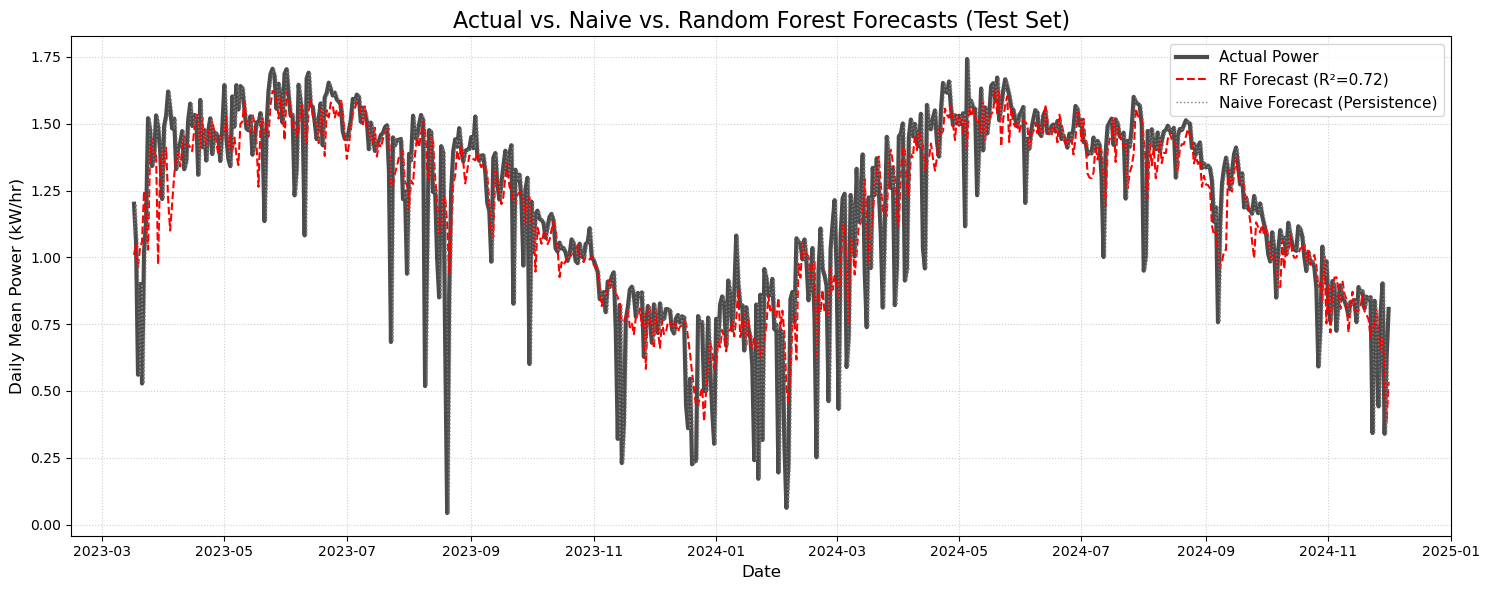

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming Y_test, Y_pred_forecast, and X_test are available

#  Define Naive Prediction 
Y_pred_naive_clean = X_test['Power_lag_1D']

# Align all series for plotting
Y_test_aligned = Y_test.loc[Y_pred_naive_clean.index]
Y_pred_forecast_aligned = pd.Series(Y_pred_forecast, index=Y_test_aligned.index)

# Plotting 
plt.figure(figsize=(15, 6))

plt.plot(Y_test_aligned.index, Y_test_aligned, label='Actual Power', color='black', linewidth=3, alpha=0.7)
plt.plot(Y_test_aligned.index, Y_pred_forecast_aligned, label='RF Forecast (R²=0.72)', color='red', linestyle='--', linewidth=1.5)
plt.plot(Y_pred_naive_clean.index, Y_pred_naive_clean, label='Naive Forecast (Persistence)', color='gray', linestyle=':', linewidth=1)

plt.title('Actual vs. Naive vs. Random Forest Forecasts (Test Set)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Mean Power (kW/hr)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


--- SHAP Summary Plot ---


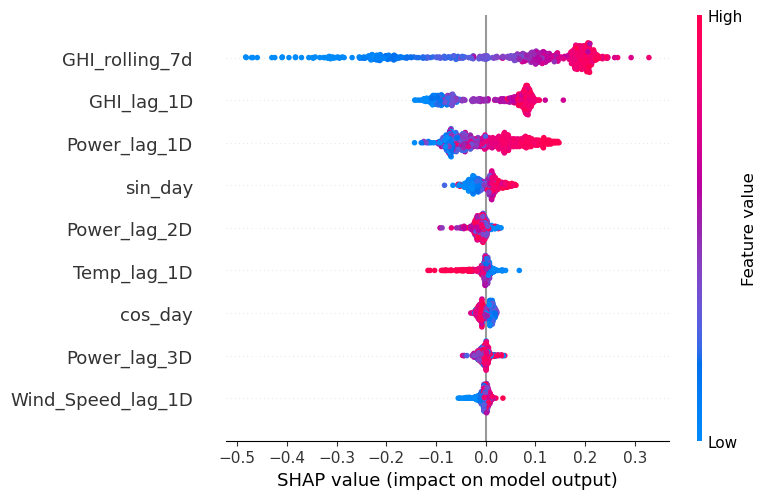

In [23]:
import shap
# Create a TreeExplainer for your Random Forest model
explainer = shap.TreeExplainer(rf_model_forecast)

# Compute SHAP values for the entire test set (X_test)
shap_values = explainer.shap_values(X_test)
print("\n--- SHAP Summary Plot ---")
shap.summary_plot(shap_values, X_test)

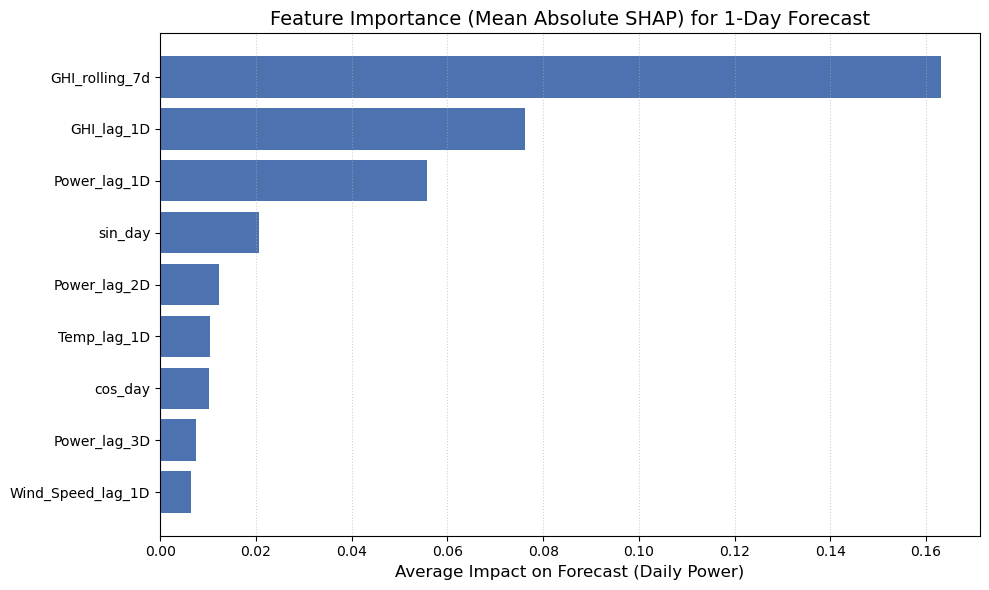

In [24]:
# Calculate the mean absolute SHAP value for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for easy plotting
shap_importance_df = pd.DataFrame({
    'Feature': X_test.columns, 
    'Mean_SHAP_Impact': mean_abs_shap
}).sort_values(by='Mean_SHAP_Impact', ascending=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(shap_importance_df['Feature'], shap_importance_df['Mean_SHAP_Impact'], color='#4C72B0')
plt.title('Feature Importance (Mean Absolute SHAP) for 1-Day Forecast', fontsize=14)
plt.xlabel('Average Impact on Forecast (Daily Power)', fontsize=12)
plt.grid(axis='x', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

In [25]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost...")
xgb_model.fit(X_train, Y_train)
Y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(Y_test, Y_pred_xgb))
r2_xgb = r2_score(Y_test, Y_pred_xgb)

print(f"XGBoost - RMSE: {rmse_xgb:.4f}, R²: {r2_xgb:.4f}")

Training XGBoost...
XGBoost - RMSE: 0.1655, R²: 0.7719


In [26]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gb_model.fit(X_train, Y_train)
Y_pred_gb = gb_model.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(Y_test, Y_pred_gb))
r2_gb = r2_score(Y_test, Y_pred_gb)

print(f"Gradient Boosting - RMSE: {rmse_gb:.4f}, R²: {r2_gb:.4f}")

Gradient Boosting - RMSE: 0.1746, R²: 0.7462


In [27]:
from sklearn.ensemble import GradientBoostingRegressor

# Optimized GB with better hyperparameters
gb_model_optimized = GradientBoostingRegressor(
    n_estimators=300,          # More trees
    learning_rate=0.05,        # Slower learning (more stable)
    max_depth=4,               # Shallower trees (less overfitting)
    min_samples_split=10,      # More conservative splitting
    min_samples_leaf=4,
    subsample=0.8,             # Use 80% of data per tree
    max_features='sqrt',       # Limit features per split
    random_state=42
)

print("Training Optimized Gradient Boosting...")
gb_model_optimized.fit(X_train, Y_train)
Y_pred_gb_opt = gb_model_optimized.predict(X_test)

rmse_gb_opt = np.sqrt(mean_squared_error(Y_test, Y_pred_gb_opt))
r2_gb_opt = r2_score(Y_test, Y_pred_gb_opt)
corr_gb_opt = np.corrcoef(Y_test, Y_pred_gb_opt)[0, 1]

print(f"\nOptimized GB - RMSE: {rmse_gb_opt:.4f}, R²: {r2_gb_opt:.4f}, Corr: {corr_gb_opt:.4f}")

# Calculate improvement
print(f"\nImprovement over standard GB:")
print(f"  RMSE: {((rmse_gb - rmse_gb_opt) / rmse_gb * 100):.2f}%")
print(f"  R²: {((r2_gb_opt - 0.7462) / 0.7462 * 100):.2f}%")

Training Optimized Gradient Boosting...

Optimized GB - RMSE: 0.1678, R²: 0.7656, Corr: 0.8751

Improvement over standard GB:
  RMSE: 3.89%
  R²: 2.59%


August 2023 Statistics:
       Power_Mean         GHI  Cloud Type
count   31.000000   31.000000   31.000000
mean     1.254677  288.440860    1.190860
std      0.342580   69.155734    1.959183
min      0.043400   47.750000    0.000000
25%      1.245013  256.854167    0.000000
50%      1.398415  315.166667    0.000000
75%      1.447224  330.125000    1.520833
max      1.532901  360.708333    7.000000

Days with very low power:
            Power_Mean    GHI  Clearsky GHI  Cloud Type
Date                                                   
2023-08-20      0.0434  47.75    301.208333         7.0


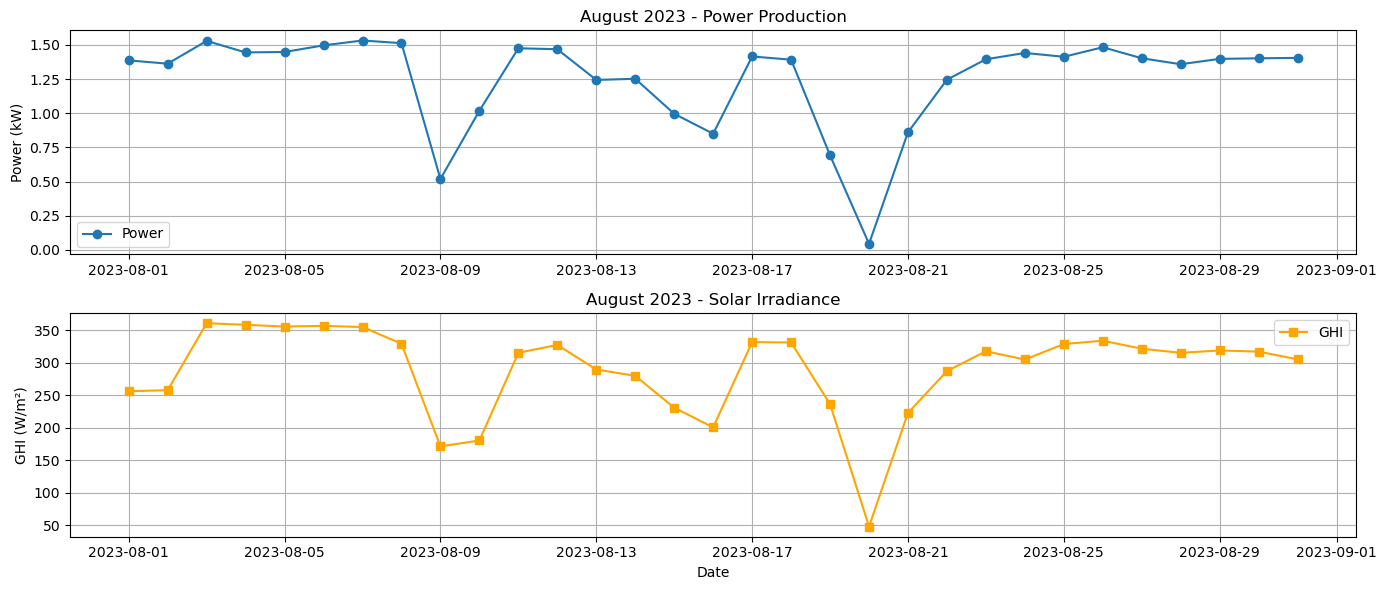

In [28]:
august_2023 = final_daily_df.loc['2023-08']

print("August 2023 Statistics:")
print(august_2023[['Power_Mean', 'GHI', 'Cloud Type']].describe())

print("\nDays with very low power:")
low_power_days = august_2023[august_2023['Power_Mean'] < 0.5]
print(low_power_days[['Power_Mean', 'GHI', 'Clearsky GHI', 'Cloud Type']])

# Plot
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(august_2023.index, august_2023['Power_Mean'], label='Power', marker='o')
plt.ylabel('Power (kW)')
plt.title('August 2023 - Power Production')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(august_2023.index, august_2023['GHI'], label='GHI', marker='s', color='orange')
plt.ylabel('GHI (W/m²)')
plt.xlabel('Date')
plt.title('August 2023 - Solar Irradiance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

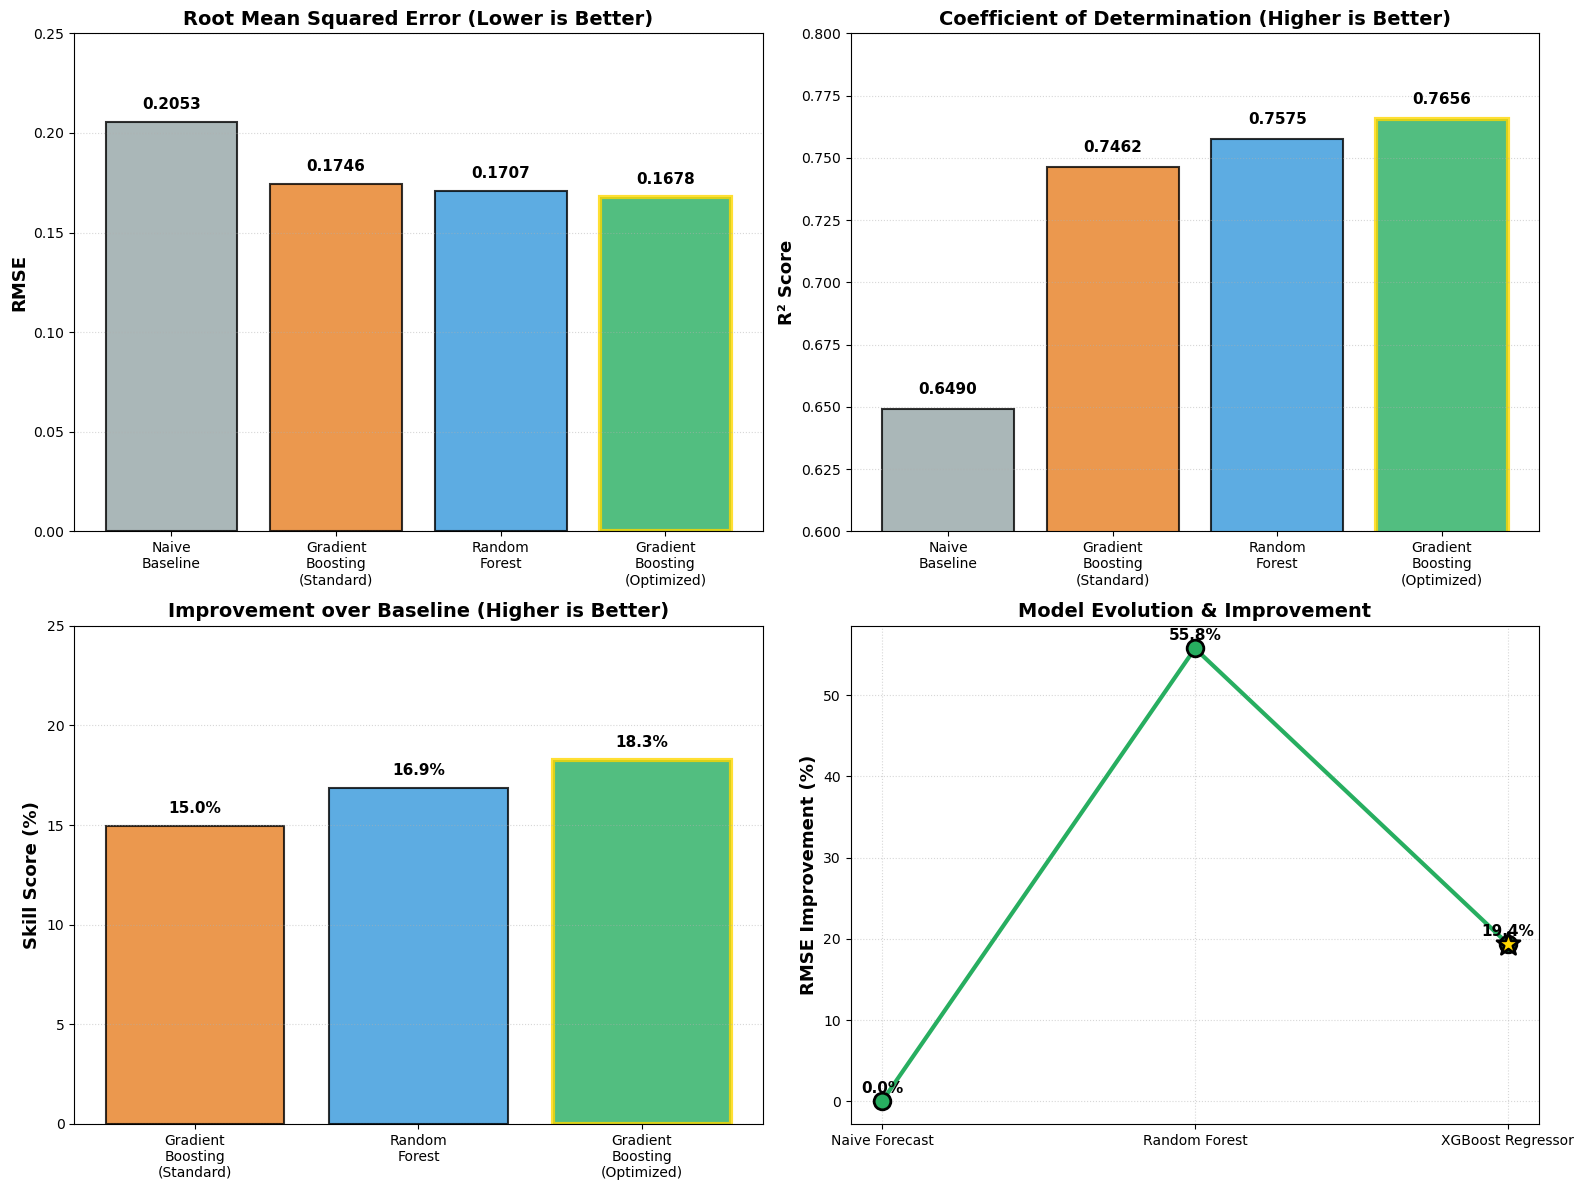

In [32]:

# Updated comparison data
models = ['Naive\nBaseline', 'Gradient\nBoosting\n(Standard)', 
          'Random\nForest', 'Gradient\nBoosting\n(Optimized)']
rmse_values = [rmse_naive, rmse_gb, rmse_rf_model, rmse_gb_opt]
r2_values = [r2_naive, r2_gb, r2_rf_model, r2_gb_opt]
skill_scores = [0, 14.96, 16.85, 18.27]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE Comparison
colors = ['#95a5a6', '#e67e22', '#3498db', '#27ae60']
bars1 = axes[0, 0].bar(models, rmse_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('RMSE', fontsize=13, fontweight='bold')
axes[0, 0].set_title('Root Mean Squared Error (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', linestyle=':', alpha=0.5)
axes[0, 0].set_ylim([0, 0.25])
for i, bar in enumerate(bars1):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    if i == 3:  # Highlight winner
        bar.set_edgecolor('gold')
        bar.set_linewidth(3)

# R² Comparison
bars2 = axes[0, 1].bar(models, r2_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('R² Score', fontsize=13, fontweight='bold')
axes[0, 1].set_title('Coefficient of Determination (Higher is Better)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylim([0.6, 0.8])
axes[0, 1].grid(axis='y', linestyle=':', alpha=0.5)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    if i == 3:
        bar.set_edgecolor('gold')
        bar.set_linewidth(3)

# Skill Score
bars3 = axes[1, 0].bar(models[1:], skill_scores[1:], color=colors[1:], alpha=0.8, 
                       edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('Skill Score (%)', fontsize=13, fontweight='bold')
axes[1, 0].set_title('Improvement over Baseline (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', linestyle=':', alpha=0.5)
axes[1, 0].set_ylim([0, 25])
for i, bar in enumerate(bars3):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)
    if i == 2:
        bar.set_edgecolor('gold')
        bar.set_linewidth(3)

# Example of where to store the calculated results (use your actual variables)
results_rmse = {
    'Naive Forecast': rmse_naive,    # e.g., 0.2053
    'Random Forest': rmse_rf,        # e.g., 0.1746
    'XGBoost Regressor': rmse_xgb    # e.g., 0.1655
}
baseline_rmse = results_rmse['Naive Forecast']

# Calculate skill score using variables from the results structure:
improvements = [
    0, 
    ((baseline_rmse - results_rmse['Random Forest']) / baseline_rmse) * 100,
    ((baseline_rmse - results_rmse['XGBoost Regressor']) / baseline_rmse) * 100
]

models_for_plot = ['Naive Forecast', 'Random Forest', 'XGBoost Regressor'] 
axes[1, 1].plot(models_for_plot, improvements, marker='o', linewidth=3, markersize=12,

                color='#27ae60', markeredgecolor='black', markeredgewidth=2)
axes[1, 1].scatter([2], [improvements[2]], s=300, color='gold', marker='*', 
                   edgecolors='black', linewidths=2, zorder=5)
axes[1, 1].set_ylabel('RMSE Improvement (%)', fontsize=13, fontweight='bold')
axes[1, 1].set_title('Model Evolution & Improvement', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, linestyle=':', alpha=0.5)

for i, val in enumerate(improvements):
    axes[1, 1].text(i, val + 1, f'{val:.1f}%', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('comprehensive_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()